# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


In [55]:
from PIL import Image
from scipy import ndimage
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
import math

# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

In [56]:
def generate_octave(init_level, s, sigma): 
    octave = [init_level] 
    k = 2**(1/s) 
    for _ in range(s+2): 
        next_level = ndimage.gaussian_filter(octave[-1],k * sigma)
        octave.append(next_level) 
    return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma): 
    pyr = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, s, sigma) 
        pyr.append(octave) 
        im = octave[-3][::2, ::2] 
    return pyr

In [57]:
def plot_pyramid(p,sz,hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image

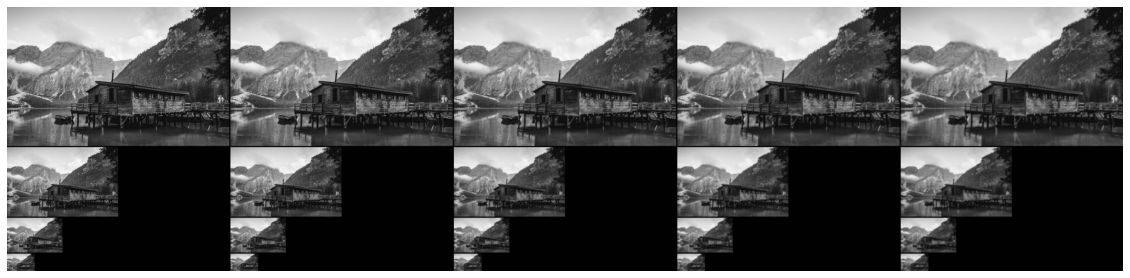

In [58]:
num_octave = 4
s = 2
sigma = 1
image = Image.open('figure1.jpg').convert('L')
image = np.array(image)
p = generate_gaussian_pyramid(image,num_octave,s,sigma)

output_pyr = plot_pyramid(p,image.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap='gray')
plt.axis('off')
plt.show()

le feature pyramid di gaussiane servono in quanto questo procedimento permette di sfruttare un'importante proprietà che ci permette di approssimare il calcolo del laplaciano di una gaussiana facendo semplice la differenza tra due gaussiane consecutive permettendo di avere una buona approssimazione del laplaciano della gaussiana risparmiando tempo di calcolo.
Per quanto riguarda il procedimento che porta alla costruzione della piramide di gaussiane è molto semplice.
L'idea è di creare lo spazio di scala che presenta nelle righe l'applicazione successiva del filtro gaussiano questo per permettere di eliminare il rumore che potrebbe porta ad un'instabilità durante il calcolo della derivata, mentre nella prima colonna a partire dalla seconda riga è presente l'ultima immagine della riga precendente però con dimensione dimezzata.
il parametro s indica il numero di immagini che otteniamo alla fine del procedimento che prevede appunto il calcolo del laplaciano della gaussiana come differenza di due gaussiane consecutive.



# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {(a*c)^5 + \exp(b^2) * \sin (d)} {3e}
$

*non sono necessarie librerie esterne*

In [61]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

a.retain_grad()
b.retain_grad()
c.retain_grad()
d.retain_grad()
e.retain_grad()

y = (a*c**5+torch.exp(b*b)*torch.sin(d))/3*e
y.retain_grad()
o = torch.sum(y)
o.retain_grad()
o.backward(retain_graph=True)

print('GRAD:')
print(f'grad a: {a.grad}')
print(f'grad b: {b.grad}')
print(f'grad c: {c.grad}')
print(f'grad d: {d.grad}')
print(f'grad e: {e.grad}')
print(f'grad y: {y.grad}')
print(f'grad o: {o.grad}')

#calcolo esplicito derivate parziali
da = torch.autograd.grad(o,a,create_graph=True)[0]
db = torch.autograd.grad(o,b,create_graph=True)[0]
dc = torch.autograd.grad(o,c,create_graph=True)[0]
dd = torch.autograd.grad(o,d,create_graph=True)[0]
de = torch.autograd.grad(o,e,create_graph=True)[0]
dy = torch.autograd.grad(o,y,create_graph=True)[0]

print(da)
print(db)
print(dc)
print(dd)
print(de)
print(dy)




GRAD:
grad a: tensor([[1.6667e+00, 2.0833e+03],
        [0.0000e+00, 5.6023e+03],
        [3.4133e+02, 8.1000e+01]])
grad b: tensor([[ 7.3681e+04, -9.0565e+03],
        [ 0.0000e+00,  1.7929e+00],
        [ 2.4336e+15,  6.1257e+01]])
grad c: tensor([[   41.6667, 12500.0000],
        [    0.0000, 32013.3340],
        [  426.6667,   270.0000]])
grad d: tensor([[-5.6201e+03,  5.1869e+03],
        [-3.3000e-01, -1.3184e-01],
        [-1.4227e+15,  9.8332e+00]])
grad e: tensor([[2.4577e+03, 5.4953e+03],
        [4.7040e-02, 4.4820e+04],
        [2.0280e+14, 1.7731e+02]])
grad y: tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
grad o: 1.0
tensor([[1.6667e+00, 2.0833e+03],
        [0.0000e+00, 5.6023e+03],
        [3.4133e+02, 8.1000e+01]], grad_fn=<MulBackward0>)
tensor([[ 7.3681e+04, -9.0565e+03],
        [ 0.0000e+00,  1.7929e+00],
        [ 2.4336e+15,  6.1257e+01]], grad_fn=<AddBackward0>)
tensor([[   41.6667, 12500.0000],
        [    0.0000, 32013.3340],
        [  426.6667,   2

# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

# Esercizio 4

Dato il seguente frammento di codice

In [ ]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

In [72]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

img=torch.rand(1,3,400,400)
model= conv2(conv1(img))

print(model.shape)


torch.Size([1, 30, 66, 50])


il risultato è un tensore 1x30x66x50

la cui size si ricava dalla formula (I-K-(k-1)(d-1)+2p)/s +1
in particolare otteniamo:
 dimensione batch =1 
numero di feature filtri applicati nell'ultima convoluzione = 30 
quindi otteniamo un'immagine che ha dimensioni 66*50 e  30 canali che sono le feature map estratte

# Esercizio 5

Adattare/semplificare la rete AlexNet affinché gestisca un input di immagini 400x400

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(400, 400, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(400 * 400 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 400 * 400 * 1)
        x = self.classifier(x)
        return x

# Esercizio 6

Data la seguente immagine, costruire due Bounding box con IoU = 0.5. 
Descrivere tutte le operazioni effettuate

![](figure2.jpg)

In [69]:
def generate_anchor_base(base_size=16, ratios=[0.5], anchor_scales=[8, 16]):
    
    py = base_size / 2
    px = base_size / 2

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)

    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            # [y_min, x_min, y_max, x_max]
            anchor_base[index, 0] = py - h / 2
            anchor_base[index, 1] = px - w / 2
            anchor_base[index, 2] = py + h / 2
            anchor_base[index, 3] = px + w / 2
            
    return anchor_base

sub_sample = 16
ratio = [0.5]
anchor_scales = [8, 16]

anchor_base = generate_anchor_base(sub_sample, ratio, anchor_scales)

print(anchor_base)

[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]]


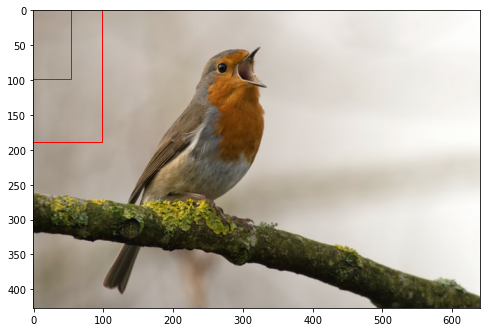

In [70]:
import matplotlib.patches as patches

def plot_bbox(image_tensor, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_tensor.numpy().transpose(1, 2, 0))

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();

import torchvision.transforms as transforms
pil2tensor = transforms.ToTensor()
image = pil2tensor(Image.open('figure2.jpg'))


plot_bbox(image, anchor_base)

